In [1]:
import os
os.getcwd()

'/Users/gavin.steininger/Desktop/HMM/orbit'

In [2]:


%load_ext autoreload
%autoreload 2



In [22]:
import orbit
import pandas as pd
import numpy as np
import copy

In [4]:
import orbit.models.ktrx 
from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx_learning import BaseKTRX_learning, KTRXFull_learning
from orbit.models.ktrx import BaseKTRX, KTRXFull

In [5]:


from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.metrics import smape

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [6]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [95]:
DATA_FILE = "./model_df.csv"
date_col = 'event_date'
response_col = 'uft'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

Unnamed: 0             int64
event_date    datetime64[ns]
uft                  float64
spend_a              float64
spend_b              float64
spend_c              float64
spend_d              float64
spend_e              float64
dtype: object

In [132]:
DATA_FILE = "./gavin_sim_data4.csv"
date_col = 'event_date'
response_col = 'uft'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

index                            int64
event_date              datetime64[ns]
uft                            float64
Video                          float64
Radio                          float64
Programmatic_Display           float64
Search_Nonbrand                float64
Display                        float64
TV                             float64
Craigslist                     float64
Social                         float64
Jobboards                      float64
Seach_Brand                    float64
dtype: object

In [136]:
regressor_col = ['spend_' + x for x in list('abcde')]
regressor_col = ['Video', 'Radio','Programmatic_Display','Search_Nonbrand','Display','TV','Craigslist','Social','Jobboards','Seach_Brand']
regressor_col

['Video',
 'Radio',
 'Programmatic_Display',
 'Search_Nonbrand',
 'Display',
 'TV',
 'Craigslist',
 'Social',
 'Jobboards',
 'Seach_Brand']

In [137]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

In [138]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.5,
    span_level=.1,
    span_coefficients=.3,
    #rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)
ktrlite.fit(train_df)

level_knot_dates = ktrlite._level_knot_dates
level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktrlite._coef_knot_dates,
    '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
    #'_sea_rho': ktrlite.rho_coefficients,
    '_seasonality': ktrlite._seasonality,
    '_seasonality_fs_order': ktrlite._seasonality_fs_order,
} 

In [140]:
ktrx = KTRXFull(
    response_col=response_col,
    date_col=date_col,
    regressor_sign = ["+","+","+","+","+","+","+","+","+","+"],
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    level_knot_scale=.2, 
    span_coefficients=0.3,
    rho_coefficients=0.15,
    regressor_col=regressor_col,
    # pyro optimization parameters
    seed=7777,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=True,
    message=100,
    estimator_type=PyroEstimatorVI,
)

ktrx.fit(train_df)



INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 70115, scale = 0.098522
step  100 loss = 8363.2, scale = 0.61459
step  200 loss = 8351.3, scale = 0.75933
step  300 loss = 8350.8, scale = 0.76898
step  400 loss = 8350.6, scale = 0.76032
step  500 loss = 8350.5, scale = 0.76807
step  600 loss = 8350.4, scale = 0.76706
step  700 loss = 8350.9, scale = 0.76941
step  800 loss = 8351.2, scale = 0.76428
step  900 loss = 8351.1, scale = 0.77311


In [141]:
coef, coef_lower, coef_upper = ktrx.get_regression_coefs(include_ci=True) # new code 
coef

,event_date,Video,Radio,Programmatic_Display,Search_Nonbrand,Display,TV,Craigslist,Social,Jobboards,Seach_Brand
0,2020-01-01,0.00254,0.02365,0.01662,0.01755,0.00235,0.00099,0.02154,0.01509,0.00234,0.00333
1,2020-01-02,0.00254,0.02365,0.01662,0.01756,0.00235,0.00099,0.02154,0.01509,0.00234,0.00333
2,2020-01-03,0.00254,0.02365,0.01662,0.01756,0.00235,0.00099,0.02154,0.01509,0.00234,0.00333
3,2020-01-04,0.00254,0.02365,0.01662,0.01756,0.00235,0.00099,0.02154,0.01509,0.00234,0.00333
4,2020-01-05,0.00254,0.02365,0.01662,0.01756,0.00235,0.00099,0.02154,0.01509,0.00234,0.00333
...,...,...,...,...,...,...,...,...,...,...,...
861,2022-05-11,0.00296,0.01950,0.01983,0.02123,0.00205,0.00103,0.02227,0.01594,0.00234,0.00293
862,2022-05-12,0.00296,0.01949,0.01983,0.02123,0.00205,0.00103,0.02227,0.01594,0.00234,0.00293
863,2022-05-13,0.00296,0.01949,0.01983,0.02123,0.00205,0.00103,0.02227,0.01594,0.00234,0.00293
864,2022-05-14,0.00296,0.01949,0.01983,0.02123,0.00205,0.00103,0.02227,0.01594,0.00234,0.00293


In [142]:
predicted_df = ktrx.predict(df=test_df) # new code 
predicted_df.head()

,event_date,prediction_5,prediction,prediction_95
0,2022-05-16,13732.35271,19287.99113,24829.85097
1,2022-05-17,11523.88294,16689.81900,22046.76456
2,2022-05-18,13933.26301,19567.29438,24745.11084
3,2022-05-19,12214.98504,17704.92868,22857.58599
4,2022-05-20,11604.48964,16911.73958,22677.34469


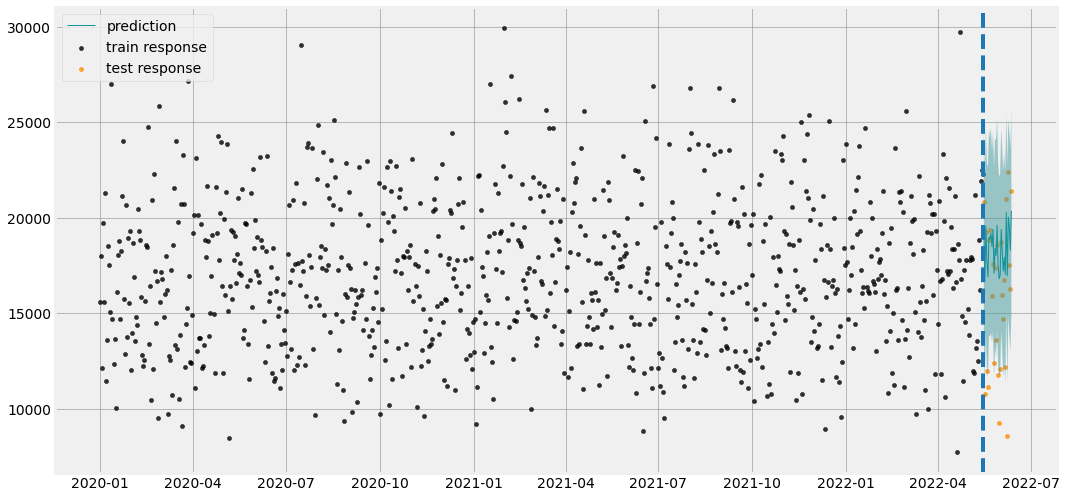

In [144]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    test_actual_df=test_df, lw=1) # old code 

In [117]:
def g_zero(df, cols = 4):
    df_new = copy.deepcopy(df) # make a copy of the df 
    for i in cols:  # loop through all columns that must be zero
        #print(i)
        df_new.iloc[:,i] = 0 
    return(df_new) # return the new df with zeros 

In [130]:
def g_pred(df, cols = [3,4,5,6,7]):
    # first the no spend case 
    df_zero = g_zero(df=df, cols = cols)
    pred_full_spend = ktrx.predict(df=df)      # prediction with the actual spend 
    pred_no_spend   = ktrx.predict(df=df_zero) # prediction with no spend

    delta_zero_mean = pred_full_spend['prediction'] - pred_no_spend['prediction'] # the delta of the two predictions 
    # question with the above should the actuals be used? 

    delta_zero_var  = ((pred_full_spend['prediction_95'] - pred_full_spend['prediction_5'])/(3.3))**2 + ((pred_no_spend['prediction_95'] - pred_no_spend['prediction_5'])/(3.3))**2
    # this is a super rough approximation. If the CI is gussian then this is the variance. it is not guassian  but .... 

    # make the output df 
    out = pd.DataFrame()
    out['event_date']  = df['event_date'] 
    out['total'] =  df['uft'] 
    out['total_pred'] = pred_full_spend['prediction']
    out['total_pred_zero'] = pred_no_spend['prediction']
    
    out['organic'] =  delta_zero_mean
    out['organic_var'] = delta_zero_var

   #loop through the channels 
    for i in cols:  # loop through all columns that must be zero
    
        print(i)
        df_temp =  g_zero(df=df, cols = [i] )
        pred_temp = ktrx.predict(df=df_temp) # prediction with no spend
        delta_temp_mean = pred_full_spend['prediction'] - pred_temp['prediction'] # the delta of the two predictions 
        # question with the above should the actuals be used? 

        delta_temp_var  = ((pred_full_spend['prediction_95'] - pred_full_spend['prediction_5'])/(3.3))**2 + ((pred_temp['prediction_95'] - pred_temp['prediction_5'])/(3.3))**2
        # this is a super rough approximation. If the CI is gussian then this is the variance. it is not guassian  but .... 
       
        out['temp_pred_WOS'] = pred_temp['prediction']
        out['temp'] =  delta_temp_mean
        out['temp_var'] = delta_temp_var


        # rename the columns 
        name  = df.columns[i]
        print(name)
        out.rename(columns={'temp': name, 
                            'temp_var': name + '_var',
                            'temp_pred_WOS':name+'_pred_WOS'}
                   ,inplace=True)


    return(out)


In [146]:
g_pred(df =df, cols = [3,4,5,6,7,8,9,10,11,12])

3
Video
4
Radio
5
Programmatic_Display
6
Search_Nonbrand
7
Display
8
TV
9
Craigslist
10
Social
11
Jobboards
12
Seach_Brand


,event_date,total,total_pred,total_pred_zero,organic,organic_var,Video_pred_WOS,Video,Video_var,Radio_pred_WOS,...,Craigslist_var,Social_pred_WOS,Social,Social_var,Jobboards_pred_WOS,Jobboards,Jobboards_var,Seach_Brand_pred_WOS,Seach_Brand,Seach_Brand_var
0,2020-01-01,15583.10000,17799.43771,16747.06186,1052.37585,21765339.95801,17638.80258,160.63513,22099788.20190,17591.41424,...,22273159.97862,17042.19352,757.24419,21581151.61990,17529.43655,270.00117,21564863.95882,17692.40945,107.02826,22205854.42330
1,2020-01-02,18010.10000,19425.27602,16709.39707,2715.87895,22274857.27387,19131.62531,293.65071,21326134.36993,19285.56002,...,24398986.74852,17018.45984,2406.81618,22515950.92576,19069.38941,355.88661,22623821.76521,19116.16230,309.11372,22708496.12186
2,2020-01-03,12162.30000,17089.84409,16799.19243,290.65167,21125621.90014,17121.29259,-31.44850,22173153.67804,17017.20541,...,21223945.97887,16965.67103,124.17307,21324192.57391,16979.28279,110.56131,20849527.42513,17006.26562,83.57847,20429763.10849
3,2020-01-04,19720.60000,19050.61201,16720.90508,2329.70693,21342593.73788,18921.86265,128.74936,21653682.34733,18770.40225,...,22167696.69391,17034.12544,2016.48657,20544655.61689,18695.93204,354.67997,21378934.39930,18935.10494,115.50707,22732616.75937
4,2020-01-05,15599.60000,18322.05803,16768.15901,1553.89902,21798102.45479,18172.26937,149.78866,21808532.70796,18329.69934,...,20326953.36111,17001.87838,1320.17965,22076802.33207,18158.41964,163.63839,20806683.18305,18233.41251,88.64552,21454406.31225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2022-06-08,8561.50000,17073.18997,16899.04823,174.14174,20863528.17782,16992.42016,80.76981,20737506.30000,16821.34343,...,19405921.02199,16979.08880,94.10118,21293136.80499,16860.37366,212.81632,21127517.27359,17148.75373,-75.56375,20799827.29601
890,2022-06-09,22414.70000,20008.92146,17003.55980,3005.36166,20402559.00981,19937.23415,71.68730,22819607.71699,19928.13639,...,22263171.01335,16952.58899,3056.33247,23117010.63332,19907.49777,101.42368,21549403.21897,19980.82785,28.09361,20800748.49058
891,2022-06-10,17549.30000,19071.65823,17012.46697,2059.19126,20611356.11401,19304.13345,-232.47522,21716015.43921,19016.17512,...,21322224.54688,17029.72393,2041.93430,20965043.13066,19446.91985,-375.26162,20787948.70214,19126.52139,-54.86316,20322814.79919
892,2022-06-11,16251.30000,18043.02020,16980.69235,1062.32785,22255860.22973,18102.94866,-59.92845,21719415.95917,18445.13432,...,21610607.20036,16980.44670,1062.57350,21789656.55815,18438.99515,-395.97495,22707132.04205,18067.18410,-24.16390,20317091.39195


In [96]:
df.shape

(894, 8)